In [1]:
import wandb
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_theme()
sns.set_context('paper')

%matplotlib inline

In [7]:
import os
dump_dir = os.path.abspath('../.log')

def parse_dump(dump):
    ts = dump.get('ts')
#     z0_orig = dump.get('z0_orig')
    true_zt = dump.get('true_zt')
#     true_zt_chaos = dump.get('true_zt_chaos')
    pred_zt = dump.get('pred_zt')

    return ts, true_zt, pred_zt

def download_runs_sweep(run_ids):
    api = wandb.Api()
    for run_id in run_ids:
        download_root = os.path.join(dump_dir, run_id)
        run = api.run("ngruver/physics-uncertainty-exps/{}".format(run_id))
        
        for f in run.files():
            if f.name != 'data.pt' and f.name != 'model.pt':
                continue
        
            fpath = os.path.join(download_root, f.name)
            if not os.path.isfile(fpath):
                f.download(root=download_root)
                
            if f.name == 'data.pt':
                data = torch.load(fpath)
            else:
                model = torch.load(fpath, map_location=torch.device('cpu'))
            
        yield run.name, run.config, model, parse_dump(data)

In [ ]:
import os
import sys
import copy
from pprint import pprint

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.models import CHNN
from src.systems.chain_pendulum import ChainPendulum
from src.train.ensemble_trainer import DeepEnsembleTrainer
    
de_run_id = ["1axj7lqk"]

for _, cfg, model_dict, (ts, true_zt, pred_zt) in download_runs_sweep(de_run_id):
    pass

os.environ['DATADIR'] = "/Users/nategruver/Desktop/"
cfg.pop('uq_type')

body = ChainPendulum(cfg.get('num_bodies', 3))
trainer = DeepEnsembleTrainer(**cfg, network=CHNN, body=body)
trainer.train(2)

trainer.model.load_state_dict(model_dict)

In [23]:
preds = trainer.model(true_zt[:,0], ts)

In [24]:
print(preds.size())

torch.Size([5, 25, 334, 2, 3, 2])


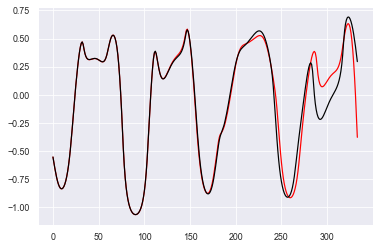

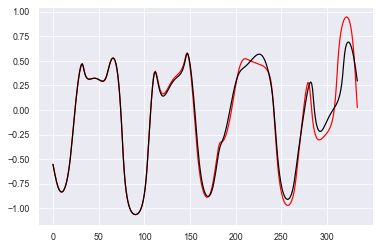

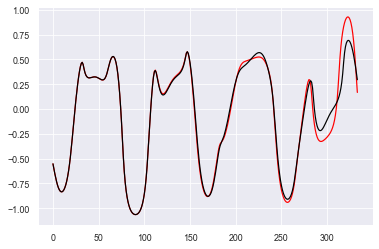

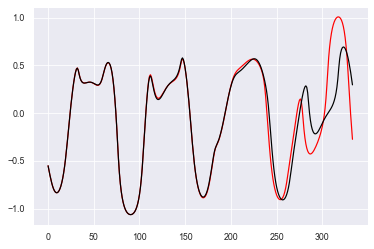

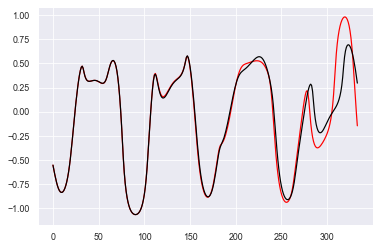

In [26]:
num_models, num_init, T = preds.shape[:3]
for i in range(1):
    for j in range(num_models):
        y_pred = preds[j, i, :, 0, 0, 0]
        y_gt = true_zt[i, :, 0, 0, 0]
        plt.plot(range(T), y_pred, color='red')
        plt.plot(range(T), y_gt, color='black')
        plt.show()
        plt.close()

In [69]:
def interpolate_models(models, model_shell, weights):
    state_dict_1 = model_1.state_dict()
    state_dict_2 = model_2.state_dict()
    interp_state_dict = copy.deepcopy(state_dict_1)
#     all_diffs = 0
    for name in interp_state_dict:
        interp_state_dict[name] = torch.zeros_like(interp_state_dict[name]).float()
        for i in range(len(models)):
            interp_state_dict[name] += weights[i] * models[i].state_dict()[name].float()
#         all_diffs += (interp_state_dict[name] - state_dict_1[name]).pow(2).sum()
    model_shell.load_state_dict(interp_state_dict)
    return model_shell
    
models = trainer.model.ensemble[:3]

losses = []
x = np.linspace(-1, 1, 10)
y = np.linspace(-1, 1, 10)
xx, yy = np.meshgrid(x, y)
W = np.column_stack([xx.flatten(), yy.flatten()])
last_col = np.ones(len(W)) - np.sum(W, axis=1)
_W = np.concatenate([W, last_col[:,np.newaxis]], axis=1)
W = _W #_W[np.where(_W[:,2] >= 0)[0]]

for idx, weights in enumerate(W):
    print("{} of {}".format(idx, len(W)))
    interp_model = interpolate_models(models, trainer.model.model, weights)
    with torch.no_grad():
        interp_preds = interp_model.integrate(true_zt[:,0], ts, method='rk4')
    loss = (interp_preds - true_zt).pow(2).mean()
#     print(loss)
    losses.append(loss)
    
losses = np.array(losses)
# z = np.zeros(len(_W))
# z[np.where(_W[:,2] >= 0)[0]] = losses
z = losses
z = z.reshape(xx.shape)
    
plt.contourf(x, y, z, cmap='cividis')
plt.show()
plt.close()

0 of 100
1 of 100
2 of 100
3 of 100
4 of 100
5 of 100
6 of 100
7 of 100
8 of 100
9 of 100
10 of 100
11 of 100
12 of 100
13 of 100
14 of 100
15 of 100
16 of 100
17 of 100
18 of 100
19 of 100
20 of 100
21 of 100
22 of 100
23 of 100
24 of 100
25 of 100
26 of 100
27 of 100
28 of 100
29 of 100
30 of 100
31 of 100
32 of 100
33 of 100


KeyboardInterrupt: 